## Water volume and tracer mass balance through the faces of the shelf box

Why do I get positive water transport in the no-canyon case if it should be balanced? Where did I screw up?

**Answer**: I never multiplied the thickness $drf$ by the fraction of open cell at the south of the cell $hfacS$ so the area of the cells ($dxg\times drf$) where water upwelled onto the shelf (close to the shelf bottom) were overestimated!

DUMB

Now, the plot at the end of this notebook shows a nice balanced shelf. Although the transport is slightly offshore throughout the simulation it can be explained by the drop in sea surface height.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty


In [4]:
# No-canyon files
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc' 
Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 
Flux = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/FluxTR01Glob.nc'

In [5]:
# Define shelf box indices
# E = east boundary, 
# W = west boundary, 
# N = north boundary (open coast), 
# S = south boundary (virtual wall from surface to shelf break).

Zind = slice(0,31)

Nx = slice(0,360) # open
Ny = 358           

Sx = slice(0,360) # open
Sy = 227

Wx = 0
Wy = slice(227,359) # periodic

Ex = 359
Ey = slice(227,359) # periodic

Lidx = slice(0,360)
Lidy = slice(227,359)
Lidz = 30

In [6]:
# Grid variables - these are the same for N and S
with Dataset(Grid, 'r') as nbl:
    dxg = nbl.variables['dxG'][Sy,Sx]
    dyg = nbl.variables['dyG'][Ey,Ex]
    drf = nbl.variables['drF'][Zind]
    depth = nbl.variables['Z'][Zind]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    ra = nbl.variables['rA'][Lidy,Lidx]
    hfacsS = nbl.variables['HFacS'][:31,Sy,Sx]
    hfacsN = nbl.variables['HFacS'][:31,Ny,Nx]


dxg_exp = np.expand_dims(dxg,0)
dyg_exp = np.expand_dims(dyg,0)
drf_exp = np.expand_dims(drf,1)
dxg_exp = dxg_exp + np.zeros(np.shape(hfacsS))
dyg_exp = dyg_exp + np.zeros((len(range(31)),len(range(359-227))))
drf_exp = drf_exp + np.zeros(np.shape(hfacsS))

In [7]:
# Calculate transport as u_i*A_i where u_i is the perpendicular velocity to the area A_i for cell i.
# East and west balance each other becasue bcs are periodic so I won't add them.
#
# Do I need to unstagger u,v?
#

# Shelf break
with Dataset(State, 'r') as nbl:
    v_south = nbl.variables['V'][:,Zind,Sy,Sx]
    S_trans = v_south*dxg_exp*hfacsS*drf_exp    # I didn't multiply by hfacS in my previous calculations
    v_north = nbl.variables['V'][:,Zind,Ny,Nx]
    N_trans = v_north*dxg_exp*hfacsN*drf_exp 
    u_east = nbl.variables['U'][:,Zind,Ey,Ex]
    E_trans = u_east*dyg_exp*drf_exp[:,Ey]
    u_west = nbl.variables['U'][:,Zind,Wy,Wx]
    W_trans = u_west*dyg_exp*drf_exp[:,Ey] 
    
    eta = nbl.variables['Eta'][:,Lidy,Lidx]     # approximation of volume change due to ssh drop
    eta_trans = ((eta[1:]-eta[:-1])*ra)/(3600*12)
    
    w_lid = nbl.variables['W'][:,Lidz,Lidy,Lidx]
    Lid_trans = w_lid*ra


S_trans_ts = np.sum(np.sum(S_trans,axis=1),axis=1)
N_trans_ts = np.sum(np.sum(N_trans,axis=1),axis=1)
E_trans_ts = np.sum(np.sum(E_trans,axis=1),axis=1)
W_trans_ts = np.sum(np.sum(W_trans,axis=1),axis=1)

eta_trans_ts = np.sum(np.sum(eta_trans,axis=1),axis=1)
Lid_trans_ts = np.sum(np.sum(Lid_trans,axis=1),axis=1)


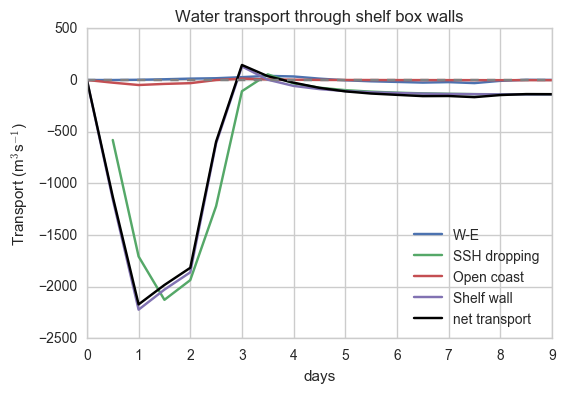

In [8]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(19)/2,W_trans_ts-E_trans_ts, label='W-E')
ax.plot(np.arange(1,19)/2,eta_trans_ts, label='SSH dropping')
ax.plot(np.arange(19)/2,N_trans_ts,label='Open coast')
ax.plot(np.arange(19)/2,S_trans_ts,label='Shelf wall')
ax.plot(np.arange(19)/2,W_trans_ts-E_trans_ts-N_trans_ts+S_trans_ts,'k',
        label='net transport')

ax.set_title('Water transport through shelf box walls')
ax.set_xlabel('days')
ax.set_ylabel('Transport (m$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')

SSH drop was not added to the net transport because the water is not actually leaving through the surface. I just waterd to see if it was enough to account for the transport through the shelf wall. Note that all the water that leaves the shelf (Shelf wall) is the same as the water transport due to the sea surface height drop. 

## Tracer balance

In [9]:
# Grid variables - these are the same for N and S
# Calculate transport as u_i*A_i where u_i is the perpendicular velocity to the area A_i for cell i.
# East and west balance each other becasue bcs are periodic so I won't add them.
#
# Do I need to unstagger u,v?
#

# Shelf break
with Dataset(Flux, 'r') as nbl:
    v_south_tr = nbl.variables['VTRAC01'][:,Zind,Sy,Sx]
    S_trans_tr = v_south_tr*dxg_exp*hfacsS*drf_exp    # I didn't multiply by hfacS in my previous calculations
    v_north_tr = nbl.variables['VTRAC01'][:,Zind,Ny,Nx]
    N_trans_tr = v_north_tr*dxg_exp*hfacsN*drf_exp 
    u_east_tr = nbl.variables['UTRAC01'][:,Zind,Ey,Ex]
    E_trans_tr = u_east_tr*dyg_exp*drf_exp[:,Ey]
    u_west_tr = nbl.variables['UTRAC01'][:,Zind,Wy,Wx]
    W_trans_tr = u_west_tr*dyg_exp*drf_exp[:,Ey] 

with Dataset(Ptracers,'r') as nbl: 
    conc_surf = nbl.variables['Tr1'][:,0,Lidy,Lidx] # pick surface level
    surf_trans_tr = (((eta[1:]*conc_surf[1:])-(eta[:-1]*conc_surf[:-1]))*ra)/(3600*12)

eta_trans_tr_ts = np.sum(np.sum(surf_trans_tr,axis=1),axis=1)
S_trans_tr_ts = np.sum(np.sum(S_trans_tr,axis=1),axis=1)
N_trans_tr_ts = np.sum(np.sum(N_trans_tr,axis=1),axis=1)
E_trans_tr_ts = np.sum(np.sum(E_trans_tr,axis=1),axis=1)
W_trans_tr_ts = np.sum(np.sum(W_trans_tr,axis=1),axis=1)



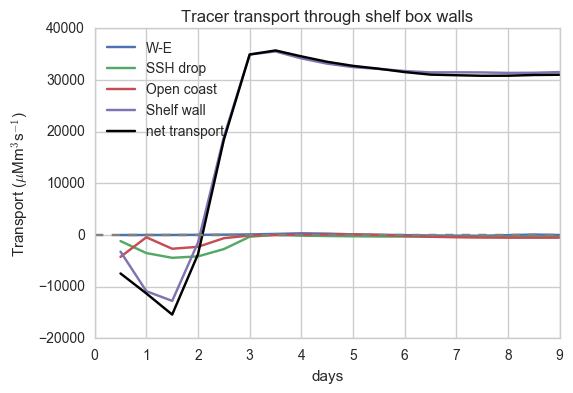

In [10]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(1,19)/2,W_trans_tr_ts-E_trans_tr_ts, label='W-E')
ax.plot(np.arange(1,19)/2,eta_trans_tr_ts,label='SSH drop')
ax.plot(np.arange(1,19)/2,-N_trans_tr_ts,label='Open coast')
ax.plot(np.arange(1,19)/2,S_trans_tr_ts,label='Shelf wall')
ax.plot(np.arange(1,19)/2,W_trans_tr_ts-E_trans_tr_ts+S_trans_tr_ts-N_trans_tr_ts,'k',label='net transport')

ax.set_title('Tracer transport through shelf box walls')
ax.set_xlabel('days')
ax.set_ylabel('Transport ($\mu$Mm$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')

Tracer transport is not zero, there is tracer coming onto the shelf throughout the whole simulation (positive transport through shelf wall)

## LOW SR - steady shelf current

In [11]:
# No canyon files - LOW SR after body forcing
PtracersL = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run02/ptracersGlob.nc' 
StateL = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run02/stateGlob.nc' 
FluxL = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run02/FluxTR01Glob.nc'

In [12]:
# Calculate transport as u_i*A_i where u_i is the perpendicular velocity to the area A_i for cell i.
# East and west balance each other becasue bcs are periodic so I won't add them.
#
# Do I need to unstagger u,v?
#

# Shelf break
with Dataset(StateL, 'r') as nbl:
    v_southL = nbl.variables['V'][:,Zind,Sy,Sx]
    S_transL = v_southL*dxg_exp*hfacsS*drf_exp    # I didn't multiply by hfacS in my previous calculations
    v_northL = nbl.variables['V'][:,Zind,Ny,Nx]
    N_transL = v_northL*dxg_exp*hfacsN*drf_exp 
    u_eastL = nbl.variables['U'][:,Zind,Ey,Ex]
    E_transL = u_eastL*dyg_exp*drf_exp[:,Ey]
    u_westL = nbl.variables['U'][:,Zind,Wy,Wx]
    W_transL = u_westL*dyg_exp*drf_exp[:,Ey] 
    
    etaL = nbl.variables['Eta'][:,Lidy,Lidx]     # approximation of volume change due to ssh drop
    eta_transL = ((etaL[1:]-etaL[:-1])*ra)/(3600*12)
    
    w_lidL = nbl.variables['W'][:,Lidz,Lidy,Lidx]
    Lid_transL = w_lidL*ra


S_trans_tsL = np.sum(np.sum(S_transL,axis=1),axis=1)
N_trans_tsL = np.sum(np.sum(N_transL,axis=1),axis=1)
E_trans_tsL = np.sum(np.sum(E_transL,axis=1),axis=1)
W_trans_tsL = np.sum(np.sum(W_transL,axis=1),axis=1)

eta_trans_tsL = np.sum(np.sum(eta_transL,axis=1),axis=1)
Lid_trans_tsL = np.sum(np.sum(Lid_transL,axis=1),axis=1)


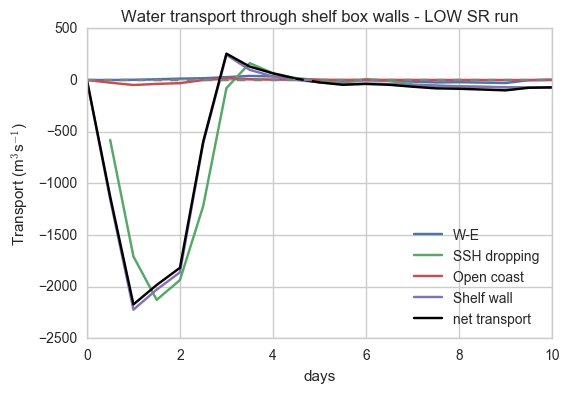

In [13]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(21)/2,W_trans_tsL-E_trans_tsL, label='W-E')
ax.plot(np.arange(1,21)/2,eta_trans_tsL, label='SSH dropping')
ax.plot(np.arange(21)/2,N_trans_tsL,label='Open coast')
ax.plot(np.arange(21)/2,S_trans_tsL,label='Shelf wall')
ax.plot(np.arange(21)/2,W_trans_tsL-E_trans_tsL-N_trans_tsL+S_trans_tsL,'k',
        label='net transport')

ax.set_title('Water transport through shelf box walls - LOW SR run')
ax.set_xlabel('days')
ax.set_ylabel('Transport (m$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')

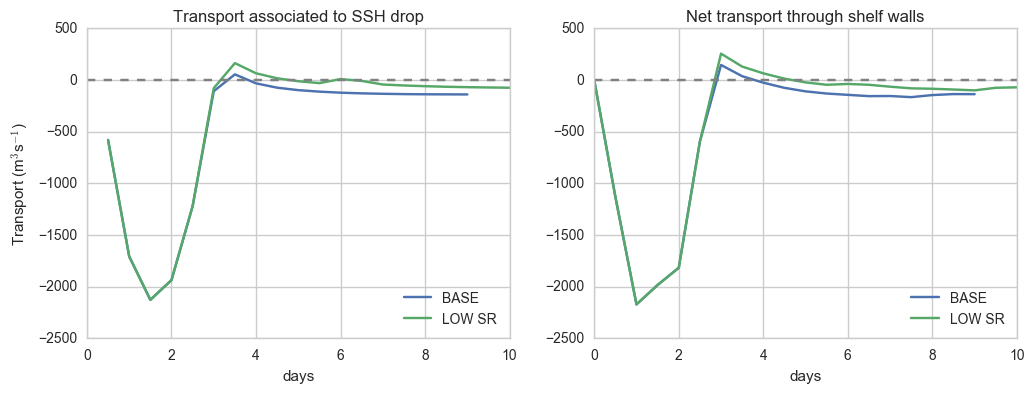

In [14]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.arange(1,19)/2,eta_trans_ts, label='BASE')
ax[0].plot(np.arange(1,21)/2,eta_trans_tsL, label='LOW SR')

ax[1].plot(np.arange(0,19)/2,W_trans_ts-E_trans_ts-N_trans_ts+S_trans_ts, label='BASE')
ax[1].plot(np.arange(0,21)/2,W_trans_tsL-E_trans_tsL-N_trans_tsL+S_trans_tsL, label='LOW SR')

ax[0].set_title('Transport associated to SSH drop')
ax[1].set_title('Net transport through shelf walls')
ax[0].set_xlabel('days')
ax[1].set_xlabel('days')
ax[0].set_ylabel('Transport (m$^3$s$^{-1}$)')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[0].axhline(0,color='0.5',linestyle='--')
ax[1].axhline(0,color='0.5',linestyle='--')

 A steadier current (with less body forcing after the initial push) reduces the SSH drop and thus the net off-shore transport. I don't know how relevant this is but it is nice to know.

## Canyon case

In [15]:
# Canyon files
GridCan = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 
PtracersCan = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
StateCan = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
FluxCan = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/FluxTR01Glob.nc'

In [16]:
# Calculate transport as u_i*A_i where u_i is the perpendicular velocity to the area A_i for cell i.
# East and west balance each other becasue bcs are periodic so I won't add them.
#
# Do I need to unstagger u,v?
#

# Shelf break
with Dataset(StateCan, 'r') as nbl:
    v_southCan = nbl.variables['V'][:,Zind,Sy,Sx]
    S_transCan = v_southCan*dxg_exp*hfacsS*drf_exp    # I didn't multiply by hfacS in my previous calculations
    v_northCan = nbl.variables['V'][:,Zind,Ny,Nx]
    N_transCan = v_northCan*dxg_exp*hfacsN*drf_exp 
    u_eastCan = nbl.variables['U'][:,Zind,Ey,Ex]
    E_transCan = u_eastCan*dyg_exp*drf_exp[:,Ey]
    u_westCan = nbl.variables['U'][:,Zind,Wy,Wx]
    W_transCan = u_westCan*dyg_exp*drf_exp[:,Ey] 
    
    etaCan = nbl.variables['Eta'][:,Lidy,Lidx]     # approximation of volume change due to ssh drop
    eta_transCan = ((etaCan[1:]-etaCan[:-1])*ra)/(3600*12)
    
    w_lidCan = nbl.variables['W'][:,Lidz,Lidy,Lidx]
    Lid_transCan = w_lidCan*ra


S_transCan_ts = np.sum(np.sum(S_transCan,axis=1),axis=1)
N_transCan_ts = np.sum(np.sum(N_transCan,axis=1),axis=1)
E_transCan_ts = np.sum(np.sum(E_transCan,axis=1),axis=1)
W_transCan_ts = np.sum(np.sum(W_transCan,axis=1),axis=1)

eta_transCan_ts = np.sum(np.sum(eta_transCan,axis=1),axis=1)
Lid_transCan_ts = np.sum(np.sum(Lid_transCan,axis=1),axis=1)


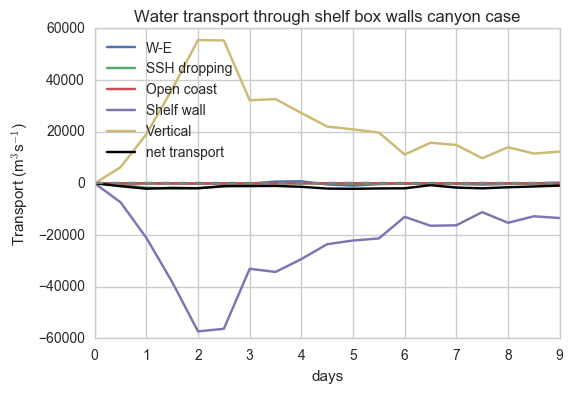

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(19)/2,W_transCan_ts-E_transCan_ts, label='W-E')
ax.plot(np.arange(1,19)/2,eta_transCan_ts, label='SSH dropping')
ax.plot(np.arange(19)/2,N_transCan_ts,label='Open coast')
ax.plot(np.arange(19)/2,S_transCan_ts,label='Shelf wall')
ax.plot(np.arange(19)/2,Lid_transCan_ts,label='Vertical')
#ax.plot(np.arange(19)/2,Lid_transCan_ts+S_transCan_ts,label='Shelf wall + Vertical')
ax.plot(np.arange(19)/2,W_transCan_ts-E_transCan_ts-N_transCan_ts+S_transCan_ts+Lid_transCan_ts,'k',
        label='net transport')

ax.set_title('Water transport through shelf box walls canyon case')
ax.set_xlabel('days')
ax.set_ylabel('Transport (m$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')

In [25]:
with Dataset(FluxCan, 'r') as nbl:
    v_southCan_tr = nbl.variables['VTRAC01'][:,Zind,Sy,Sx]
    S_transCan_tr = v_southCan_tr*dxg_exp*hfacsS*drf_exp    # I didn't multiply by hfacS in my previous calculations
    v_northCan_tr = nbl.variables['VTRAC01'][:,Zind,Ny,Nx]
    N_transCan_tr = v_northCan_tr*dxg_exp*hfacsN*drf_exp 
    u_eastCan_tr = nbl.variables['UTRAC01'][:,Zind,Ey,Ex]
    E_transCan_tr = u_eastCan_tr*dyg_exp*drf_exp[:,Ey]
    u_westCan_tr = nbl.variables['UTRAC01'][:,Zind,Wy,Wx]
    W_transCan_tr = u_westCan_tr*dyg_exp*drf_exp[:,Ey] 
    w_lidCan_tr = nbl.variables['WTRAC01'][:,Lidz,Lidy,Lidx]
    Lid_transCan_tr = w_lidCan_tr*ra

with Dataset(PtracersCan,'r') as nbl: 
    conc_surfCan = nbl.variables['Tr1'][:,0,Lidy,Lidx] # pick surface level
    surf_transCan_tr = (((etaCan[1:]*conc_surfCan[1:])-(etaCan[:-1]*conc_surfCan[:-1]))*ra)/(3600*12)

eta_transCan_tr_ts = np.sum(np.sum(surf_transCan_tr,axis=1),axis=1)
S_transCan_tr_ts = np.sum(np.sum(S_transCan_tr,axis=1),axis=1)
N_transCan_tr_ts = np.sum(np.sum(N_transCan_tr,axis=1),axis=1)
E_transCan_tr_ts = np.sum(np.sum(E_transCan_tr,axis=1),axis=1)
W_transCan_tr_ts = np.sum(np.sum(W_transCan_tr,axis=1),axis=1)
lid_transCan_tr_ts = np.sum(np.sum(Lid_transCan_tr,axis=1),axis=1)



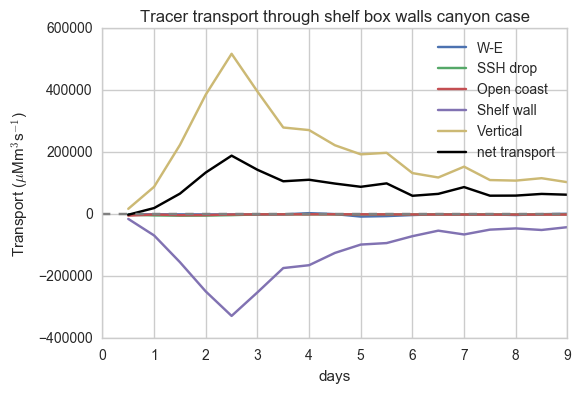

In [26]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(1,19)/2,W_transCan_tr_ts-E_transCan_tr_ts, label='W-E')
ax.plot(np.arange(1,19)/2,eta_transCan_tr_ts,label='SSH drop')
ax.plot(np.arange(1,19)/2,-N_transCan_tr_ts,label='Open coast')
ax.plot(np.arange(1,19)/2,S_transCan_tr_ts,label='Shelf wall')
ax.plot(np.arange(1,19)/2,lid_transCan_tr_ts,label='Vertical')

ax.plot(np.arange(1,19)/2,W_transCan_tr_ts-E_transCan_tr_ts+S_transCan_tr_ts-N_transCan_tr_ts+
        lid_transCan_tr_ts,'k',label='net transport')

ax.set_title('Tracer transport through shelf box walls canyon case')
ax.set_xlabel('days')
ax.set_ylabel('Transport ($\mu$Mm$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(np.arange(1,19)/2,W_transCan_tr_ts-E_transCan_tr_ts+S_transCan_tr_ts-N_transCan_tr_ts+
        lid_transCan_tr_ts,label='net transport canyon')
ax.plot(np.arange(1,19)/2,W_trans_tr_ts-E_trans_tr_ts+S_trans_tr_ts-N_trans_tr_ts
        ,label='net transport no canyon')
ax.plot(np.arange(1,19)/2,(W_transCan_tr_ts-E_transCan_tr_ts+S_transCan_tr_ts-N_transCan_tr_ts+
        lid_transCan_tr_ts)-(W_trans_tr_ts-E_trans_tr_ts+S_trans_tr_ts-N_trans_tr_ts),
        'k',label='net transport anomaly')


ax.set_title('Tracer transport through shelf box walls')
ax.set_xlabel('days')
ax.set_ylabel('Transport ($\mu$Mm$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')